In [37]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly
import plotly.offline as py
import plotly.graph_objs as go
import warnings
import seaborn as sns
import pandas_profiling
from shapely.geometry import Point
import folium
import datetime
from dateutil import relativedelta
import matplotlib.cm as cm
import matplotlib
from datetime import datetime

# Preprocessing
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# model
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

# yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Pipeline
from sklearn.pipeline import Pipeline

# GridSearch and cross-validation
from sklearn.model_selection import GridSearchCV

pd.set_option('max_columns', None)
%matplotlib inline
# pycodestyle_magic
%load_ext pycodestyle_magic
%flake8_on
# figures style
sns.set_style("whitegrid")

1: E999 SyntaxError: invalid syntax


The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


# Choosing a clustering method

In [38]:
data = pd.read_csv('data_segmentation.csv')

# RFM analysis
A RFM analysis will be performed for all database

In [39]:
from datetime import date
# dropping orders with price == 0
data = data[(data.price != 0) &
            (data.price.notnull())]

# working with date
data.order_purchase_timestamp = pd.to_datetime(data.
                                               order_purchase_timestamp).\
                                    dt.date


# selecting data between 01/2017 and 08/2018
# start_date = date(int(2017), int(1), int(1))
start_date = data.order_purchase_timestamp.min()
end_date = data.order_purchase_timestamp.max()
# end_date = date(int(2018), int(8), int(31))
period = (end_date - start_date).days

print('period of study:', period, 'days')
print('from: ', start_date, ' to ', end_date)
print(data.shape)
data = data[(data.order_purchase_timestamp >= start_date) &
            (data.order_purchase_timestamp <= end_date)]
data = data.reset_index(drop=True)

period of study: 729 days
from:  2016-09-04  to  2018-09-03
(98666, 15)


### Features

In [40]:
# New features for RFM analysis
# Quantity of purchases to determine frequency
# Rencency: days between last purchase and the
# end date  used in the analysis
data['n_purchase'] = 1
data['recency'] = (end_date - data.order_purchase_timestamp)
data['recency'] = data.recency.dt.days

Creating a dataframe for RFM score analysis. The ```groupby``` fonciton is used to get:
- frequency: number of purchases that have been donne for the period of study
- recency: number of days since last purchae
- monetary: total amount of money exped for the period of study

In [41]:
rfm = data[['customer_unique_id', 'n_purchase', 'recency', 'price']]
rfm = rfm.groupby('customer_unique_id').agg({
                                             'n_purchase': 'sum',
                                             'recency': 'min',
                                             'price': 'sum'})
rfm = rfm.reset_index()
rfm = rfm.rename(columns={'n_purchase': 'frequency', 'price': 'monetary'})
rfm

customer_unique_id  frequency  recency  monetary
0      0000366f3b9a7992bf8c76cfdf3221e2          1      116    129.90
1      0000b849f77a49e4a4ce2b2a4ca5be3f          1      119     18.90
2      0000f46a3911fa3c0805444483337064          1      542     69.00
3      0000f6ccb0745a6a4b88665a16c9f078          1      326     25.99
4      0004aac84e0df4da2b147fca70cf8255          1      293    180.00
...                                 ...        ...      ...       ...
95415  fffcf5a5ff07b0908bd4e2dbc735a684          1      452   1570.00
95416  fffea47cd6d3cc0a88bd621562a9d061          1      267     64.89
95417  ffff371b4d645b6ecea244b27531430a          1      573     89.90
95418  ffff5962728ec6157033ef9805bacc48          1      124    115.00
95419  ffffd2657e2aad2907e67c3e9daecbeb          1      489     56.99

[95420 rows x 4 columns]

In [42]:
rfm.describe()

frequency       recency      monetary
count  95420.000000  95420.000000  95420.000000
mean       1.034018    243.501457    142.440198
std        0.211234    153.160850    217.656355
min        1.000000      0.000000      0.850000
25%        1.000000    119.000000     47.900000
50%        1.000000    224.000000     89.900000
75%        1.000000    353.000000    155.000000
max       16.000000    729.000000  13440.000000

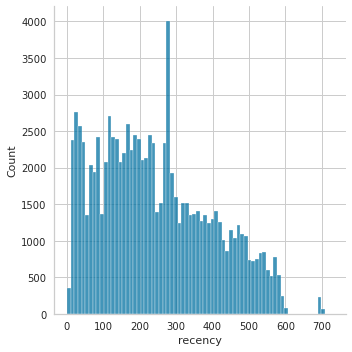

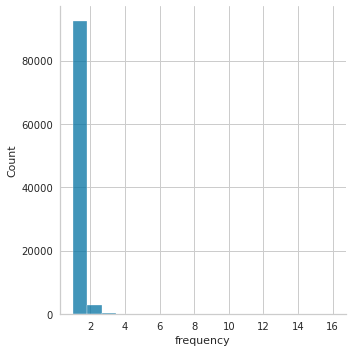

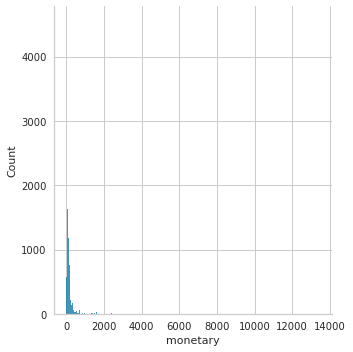

In [43]:
sns.displot(rfm.recency)
sns.displot(rfm.frequency)
sns.displot(rfm.monetary)

Text(0.5, 0.98, 'RFM variables descriptions')

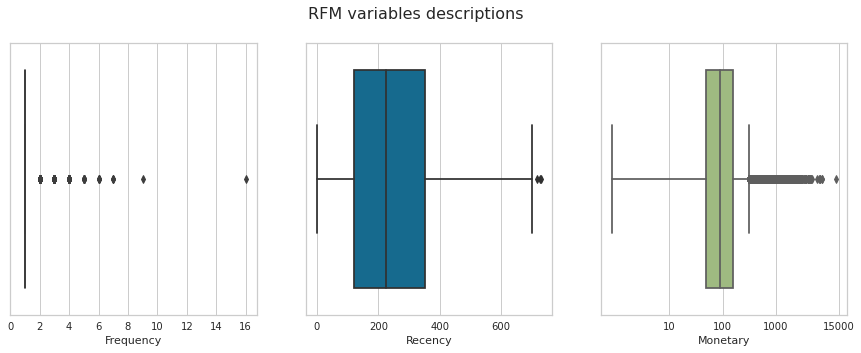

In [44]:
fig1, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(data=rfm, x='frequency', ax=ax[0], color='r')
ax[0].set(xlabel='Frequency')
ax[0].set(xticks=np.arange(0, 18, 2))
sns.boxplot(data=rfm, x='recency', ax=ax[1])
ax[1].set(xlabel='Recency')
sns.boxplot(data=rfm, x='monetary', ax=ax[2], color='g')
ax[2].set(xlabel='Monetary')
ax[2].set_xscale('log')
ax[2].set_xticks([10, 100, 1000, 15000])
ax[2].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

fig1.suptitle('RFM variables descriptions', fontsize=16)


In [64]:
# Calculate R and F groups
# create lables for recency and frequency
r_labels = range(4, 0, -1)
f_labels = range(1, 5)

# assign labels for recency
r_group = pd.qcut(rfm.recency, q=4, labels=r_labels)
# assign labels for freqency


def f_labels(x):
    if x > 1:
        return 4
    else:
        return 1


f_group = rfm.frequency.apply(lambda x: f_labels(x))

# assign labels for recency
m_labels = range(1, 5)
m_group = pd.qcut(rfm.monetary, q=4, labels=m_labels)

# create new columns
rfm = rfm.assign(R=r_group.values, F=f_group, M=m_group)
rfm.head()

customer_unique_id  frequency  recency  monetary  R  F  M  \
0  0000366f3b9a7992bf8c76cfdf3221e2          1      116    129.90  4  1  3   
1  0000b849f77a49e4a4ce2b2a4ca5be3f          1      119     18.90  4  1  1   
2  0000f46a3911fa3c0805444483337064          1      542     69.00  1  1  2   
3  0000f6ccb0745a6a4b88665a16c9f078          1      326     25.99  2  1  1   
4  0004aac84e0df4da2b147fca70cf8255          1      293    180.00  2  1  4   

  RFM_segment  RFM_score  
0         413          8  
1         411          6  
2         112          4  
3         211          4  
4         214          7

In [65]:
# Concat r-f-m to create RFM segments
def join_rfm(x):
    return str(x['R'])+str(x['F'])+str(x['M'])


rfm['RFM_segment'] = rfm.apply(join_rfm, axis=1)
rfm

customer_unique_id  frequency  recency  monetary  R  F  \
0      0000366f3b9a7992bf8c76cfdf3221e2          1      116    129.90  4  1   
1      0000b849f77a49e4a4ce2b2a4ca5be3f          1      119     18.90  4  1   
2      0000f46a3911fa3c0805444483337064          1      542     69.00  1  1   
3      0000f6ccb0745a6a4b88665a16c9f078          1      326     25.99  2  1   
4      0004aac84e0df4da2b147fca70cf8255          1      293    180.00  2  1   
...                                 ...        ...      ...       ... .. ..   
95415  fffcf5a5ff07b0908bd4e2dbc735a684          1      452   1570.00  1  1   
95416  fffea47cd6d3cc0a88bd621562a9d061          1      267     64.89  2  1   
95417  ffff371b4d645b6ecea244b27531430a          1      573     89.90  1  1   
95418  ffff5962728ec6157033ef9805bacc48          1      124    115.00  3  1   
95419  ffffd2657e2aad2907e67c3e9daecbeb          1      489     56.99  1  1   

       M RFM_segment  RFM_score  
0      3         413          8  
1      1         411          6  
2      2         112          4  
3      1         211          4  
4      4         214          7  
...   ..         ...        ...  
95415  4         114          6  
95416  2         212          5  
95417  2         112          4  
95418  3         313          7  
95419  2         112          4  

[95420 rows x 9 columns]

In [66]:
# number of unique clients
number_of_clients = rfm.groupby('RFM_segment')['RFM_segment'].\
                    nunique().sum()
print('there are', number_of_clients,
      'types of clients')

# Calculatinf RFM score for customers
rfm['RFM_score'] = rfm[['R', 'F', 'M']].sum(axis=1)
rfm.head()

there are 32 types of clients


customer_unique_id  frequency  recency  monetary  R  F  M  \
0  0000366f3b9a7992bf8c76cfdf3221e2          1      116    129.90  4  1  3   
1  0000b849f77a49e4a4ce2b2a4ca5be3f          1      119     18.90  4  1  1   
2  0000f46a3911fa3c0805444483337064          1      542     69.00  1  1  2   
3  0000f6ccb0745a6a4b88665a16c9f078          1      326     25.99  2  1  1   
4  0004aac84e0df4da2b147fca70cf8255          1      293    180.00  2  1  4   

  RFM_segment  RFM_score  
0         413          8  
1         411          6  
2         112          4  
3         211          4  
4         214          7

Text(0.5, 0.98, 'RFM segment score')

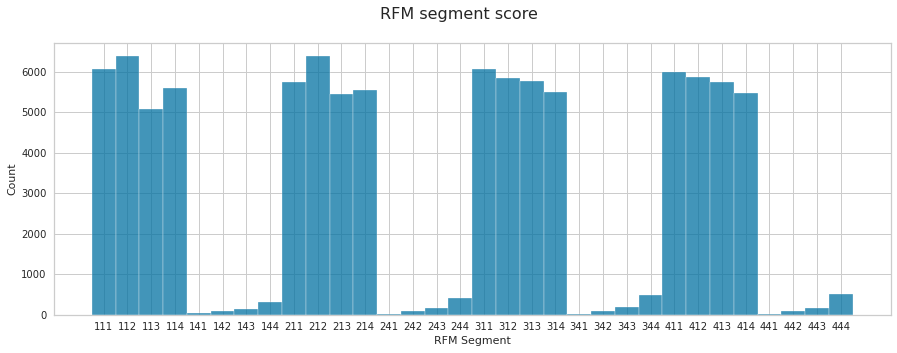

In [67]:
# plot distribution of RFM segment
fig2, ax = plt.subplots(1, figsize=(15, 5))
sns.histplot(rfm.RFM_segment.sort_values(), ax=ax)
ax.set(xlabel='RFM Segment', ylabel='Count')
fig2.suptitle('RFM segment score', fontsize=16)

Text(0.5, 1.0, 'RFM score distribution')

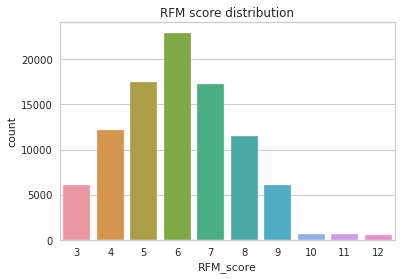

In [68]:
fig = sns.countplot(data=rfm, x='RFM_score', dodge=False)
fig.set_title('RFM score distribution')

In [69]:
# description of scores
rfm.RFM_score.describe()

count    95420.000000
mean         6.081084
std          1.726149
min          3.000000
25%          5.000000
50%          6.000000
75%          7.000000
max         12.000000
Name: RFM_score, dtype: float64

In [71]:
# labels for customers
c_labels = ['need attention', 'potential', 'best customers']
cuts = [0, 0.25, 0.75, 1]
rfm['RFM_level'] = pd.qcut(rfm.RFM_score, cuts, labels=c_labels)
rfm.head()

customer_unique_id  frequency  recency  monetary  R  F  M  \
0  0000366f3b9a7992bf8c76cfdf3221e2          1      116    129.90  4  1  3   
1  0000b849f77a49e4a4ce2b2a4ca5be3f          1      119     18.90  4  1  1   
2  0000f46a3911fa3c0805444483337064          1      542     69.00  1  1  2   
3  0000f6ccb0745a6a4b88665a16c9f078          1      326     25.99  2  1  1   
4  0004aac84e0df4da2b147fca70cf8255          1      293    180.00  2  1  4   

  RFM_segment  RFM_score       RFM_level  
0         413          8  best customers  
1         411          6       potential  
2         112          4  need attention  
3         211          4  need attention  
4         214          7       potential

Text(0.5, 1.0, 'Distribution of type of consumers from RFM')

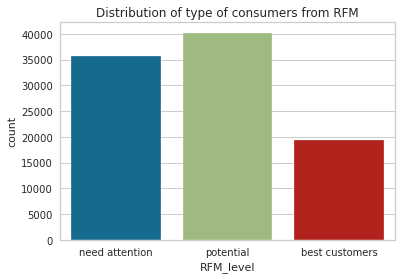

In [72]:
fig9 = sns.countplot(data=rfm, x='RFM_level', dodge=False)
fig9.set_title('Distribution of type of consumers from RFM')

In [74]:
px.scatter(rfm, x='frequency',
           y='monetary', color='RFM_level', size='recency')

Text(0.5, 1.0, 'Money spend by each customer class')

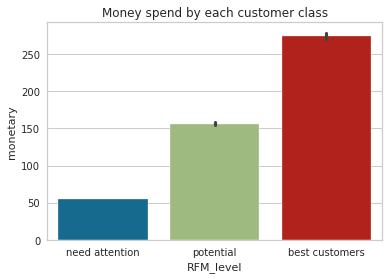

In [75]:
fig8 = sns.barplot(data=rfm, x='RFM_level', y='monetary')
fig8.set_title('Money spend by each customer class')

<AxesSubplot:xlabel='RFM_level', ylabel='recency'>

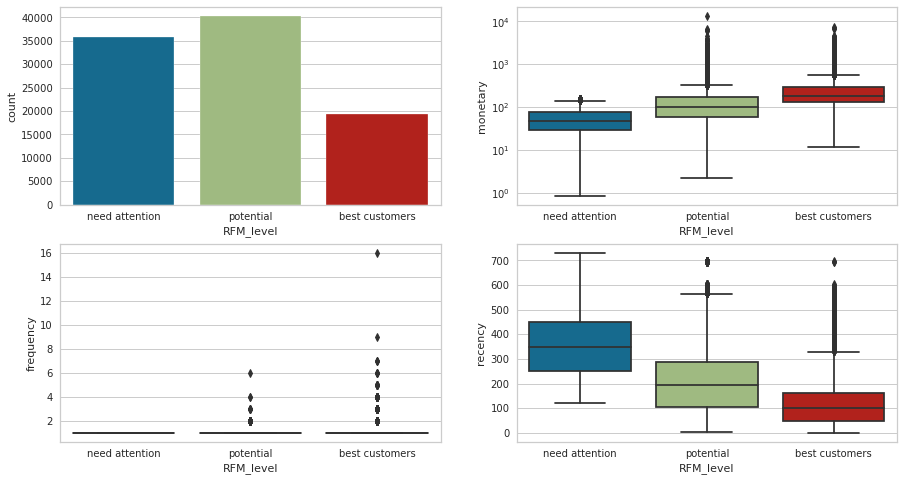

In [83]:
fig3, ax = plt.subplots(2, 2, figsize=(15, 8))
sns.countplot(ax=ax[0, 0], data=rfm, x='RFM_level')
sns.boxplot(ax=ax[0, 1], data=rfm, x='RFM_level', y='monetary')
ax[0, 1].set(yscale='log')
sns.boxplot(ax=ax[1, 0], data=rfm, x='RFM_level', y='frequency')
sns.boxplot(ax=ax[1, 1], data=rfm, x='RFM_level', y='recency')

In [78]:
# Count customers
rfm_level_count = rfm.groupby('RFM_level').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']
}).round(1)
rfm_level_count

recency frequency monetary       
                  mean      mean     mean  count
RFM_level                                       
need attention   350.2       1.0     55.3  35731
potential        210.8       1.0    156.1  40214
best customers   115.2       1.2    274.1  19475

In [79]:
# treeplot
rfm_level_count.columns = rfm_level_count.columns.droplevel()
rfm_level_count.columns = ['RecencyMean', 'FrequencyMean',
                           'MonetaryMean', 'Count']
rfm_level_count

RecencyMean  FrequencyMean  MonetaryMean  Count
RFM_level                                                      
need attention        350.2            1.0          55.3  35731
potential             210.8            1.0         156.1  40214
best customers        115.2            1.2         274.1  19475

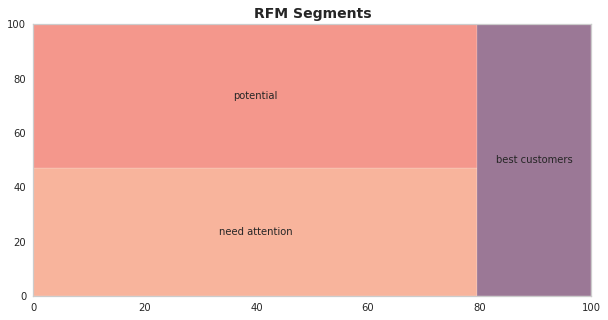

In [81]:
import squarify
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(10, 5)
plt.grid(False)
squarify.plot(sizes=rfm_level_count['Count'], label=c_labels, alpha=0.6)
plt.title("RFM Segments", fontsize=14, fontweight="bold")
plt.show()

## Conclusions
The recency, frequency and monetary of each customer has been calculated. The RFM_segmentation of the data set shows 62 types of customers, in order to summarize this the RFM score was calculated additioning the R-F-M value.
The RFM_score was used to determine 3 types of customers, the quantiles Q1 and Q3 were used:
- Need attention: [min, Q1);
- Potential: [Q1, Q3);
- Best customers: [Q3, max]

40% of the customers needs attention and 40% are potential customers.

# Unsupervised machine learning algorithms
Using DBSCAN and K-means to cluster customers

# Baseline model K-mean
This first model will used as features de R-F-M features.

Text(0.5, 1.0, 'Correlation between features')

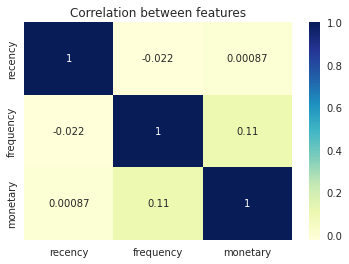

In [88]:
data_bm = pd.DataFrame(rfm[['recency', 'frequency', 'monetary']])
fig10 = sns.heatmap(data_bm.corr(), cmap='YlGnBu', annot=True)
fig10.set_title('Correlation between features')

In [89]:
# Preprocessing
X = rfm[['recency', 'frequency', 'monetary']]

preprocessor = ColumnTransformer(transformers=[
                                               ('scaler', StandardScaler(),
                                                ['recency',
                                                 'frequency',
                                                 'monetary'])])

X_trans = pd.DataFrame(preprocessor.fit_transform(X), columns=X.columns)

In [90]:
print(X.shape)
# sns.boxplot(data=(X_trans))

(95420, 3)


### Elbow method

In [91]:
# find K value for K_mean model
# elbow method

def elbow_method(k_min, k_max, data_trans):
    elbow = []
    K = range(k_min, k_max)
    for k in K:
        model = KMeans(n_clusters=k, random_state=40, init='k-means++')
        clf = model.fit(data_trans)
        inertia = clf.inertia_
        elbow.append(inertia)

    results = pd.DataFrame({'k': K, 'Inertia': elbow})

    return results

In [92]:
# running elbow method for baseline model
bl_elbow = elbow_method(1, 10, X_trans)

In [93]:
fig1 = px.line(bl_elbow, x='k', y='Inertia',
               title='Elbow Method showing the optimal number of clusters',
               labels={'x': 'Number of clusters', 'y': 'Inertie'},
               width=800, height=600)
fig1.update_traces(mode='markers+lines')

**The elbow method allow us to determine the most suitable number of clusters, in this case k=4.**
### Silhouette score

In [27]:
def sil_score(k_min, k_max, data_trans):
    sc = []
    K = range(k_min, k_max)
    for k in K:
        model = KMeans(n_clusters=k, random_state=40,
                       init='k-means++')
        labels = model.fit_predict(data_trans)
        score = silhouette_score(data_trans, labels)
        print('k:', k, 'score:', score)
        sc.append(score)

    results = pd.DataFrame({'k': K, 'sil_scores': sc})

    return results

In [28]:
# scores = sil_score(2, 6, X_trans)
# px.line(scores, x='k', y='sil_scores')

## Implementing K-mean clustering
- pre-processing : StandardScaler()
- k = 4,
- init = 'k-mean++'

In [29]:
# dataframe to summarize information
# from models
models_info = pd.DataFrame(columns=['model',
                                    'n_clusters',
                                    'score',
                                    'inertia',
                                    'time'])

In [30]:
# Creating model for 4 clusters
start = datetime.now()

# model
k = 4
model = KMeans(n_clusters=k, random_state=40,
               init='k-means++')

# fit, labels and inertia
clf = model.fit(X_trans)
labels = model.fit_predict(X_trans)
score = silhouette_score(X_trans, labels)
inertia = clf.inertia_

end = datetime.now()
time = end - start

In [31]:
models_info = models_info.append({'model': 'rfm_kmean',
                                  'n_clusters': k,
                                  'score': score,
                                  'inertia': inertia,
                                  'time': time.total_seconds()},
                                 ignore_index=True)
models_info

model n_clusters     score       inertia       time
0  rfm_kmean          4  0.490767  94311.470967  103.86471

In [32]:
# preparing dataframe with labels
base_kmean = pd.DataFrame(rfm[['customer_unique_id',
                               'frequency', 'recency',
                               'monetary']])
base_kmean['label'] = labels

In [33]:
# Fonction to plot the silhouette diagramme


def silhouette_diagram(k, model):
    K = [k]
    for k in K:
        fig, ax1 = plt.subplots()
        fig.set_size_inches(18, 7)
        # set lim on y_axis
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        ax1.set_ylim([0, len(X_trans) + (k + 1)*10])

        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        cluster_labels = model.fit_predict(X_trans)
        # Silhouette average score
        silhouette_avg = silhouette_score(X_trans, cluster_labels)

        print('average score for k =', k, ' is ', silhouette_avg)

        # Silhouette score for each sample
        sample_silhouette_val = silhouette_samples(X_trans, cluster_labels)

        y_lower = 10

        for i in range(k):
            # The (n_clusters+1)*10 is for inserting blank
            # space between silhouette
            cluster_silhouette_values = sample_silhouette_val[
                                        cluster_labels == i]

            cluster_silhouette_values.sort()

            size_cluster_i = cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / k)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster
            # numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()

In [34]:
# silhouette_diagram(k, model)

In [35]:
# base_kmean[base_kmean.label==0].describe()

<AxesSubplot:xlabel='label', ylabel='recency'>

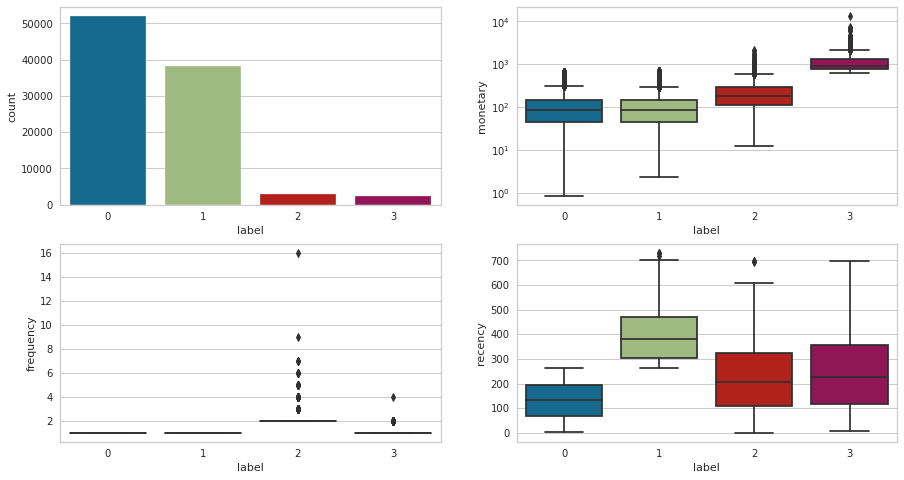

In [36]:
fig3, ax = plt.subplots(2, 2, figsize=(15, 8))
sns.countplot(ax=ax[0, 0], data=base_kmean, x='label')
sns.boxplot(ax=ax[0, 1], data=base_kmean, x='label', y='monetary')
ax[0, 1].set(yscale='log')
sns.boxplot(ax=ax[1, 0], data=base_kmean, x='label', y='frequency')
sns.boxplot(ax=ax[1, 1], data=base_kmean, x='label', y='recency')

In [37]:
fig = px.parallel_coordinates(base_kmean, color='label',
                              dimensions=['frequency',
                                          'recency',
                                          'monetary'],
                              color_continuous_scale=px.colors.
                              diverging.Tealrose,
                              color_continuous_midpoint=2)
# fig.show()

## DBSCAN
Density-based algorithm. Defines clusters as dense regions of space separated by low-density.
Parameters:
- Epsilon: radius of  the area around the point defining the maximum distance between such point and any other points in the neighborhood of the other.
- min points: minimum number of points present in the neighborhood required to form a cluster

In [38]:
# Data selection
X_dbscan = pd.DataFrame(rfm[['recency', 'monetary', 'frequency']])
X_min = X_dbscan.sample(10000)
# Data transformation
scaler = StandardScaler()
X_tdbscan = pd.DataFrame(scaler.fit_transform(X_min),
                         columns=X_dbscan.columns)
X_tdbscan

recency  monetary  frequency
0     0.242555 -0.235730  -0.170389
1     0.018895 -0.231065  -0.170389
2    -0.310017 -0.251594  -0.170389
3    -0.790228 -0.183941  -0.170389
4    -0.862589 -0.483012  -0.170389
...        ...       ...        ...
9995 -0.310017 -0.324378  -0.170389
9996 -1.395426  0.002220  -0.170389
9997 -0.645507  1.682286  -0.170389
9998 -1.198079 -0.277302  -0.170389
9999 -1.132296 -0.183988  -0.170389

[10000 rows x 3 columns]

In [39]:
# calculate the distance from each point
# to its closest neighbour
min_samples = 2 * len(X_tdbscan.columns)

neigh = NearestNeighbors(n_neighbors=min_samples)
nbrs = neigh.fit(X_tdbscan)
distances, indices = nbrs.kneighbors(X_tdbscan)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

distances
px.line(distances)

In [40]:
eps = [0.4, 0.8, 1, 1.5]
S = []
comb = []
for k in eps:
    model = DBSCAN(eps=k, min_samples=min_samples)
    clm = model.fit(X_tdbscan)
    S.append(silhouette_score(X_tdbscan, clm.labels_))
    comb.append(str(k))

In [41]:
px.line(x=comb, y=S, labels={'y': 'score', 'x': 'epsilon'})

In [42]:
eps_final = 0.8
m_dbscan = DBSCAN(eps=eps_final,
                  min_samples=min_samples,
                  metric='euclidean',
                  algorithm='auto')

clm_dbscan = m_dbscan.fit(X_tdbscan)

In [43]:
# getting labels
X_min['label'] = clm_dbscan.labels_
X_min

recency  monetary  frequency  label
90274      280     88.90          1      0
28903      246     89.90          1      0
51060      196     85.50          1      0
28184      123    100.00          1      0
91505      112     35.90          1      0
...        ...       ...        ...    ...
71544      196     69.90          1      0
26111       31    139.90          1      0
52656      145    499.99          1      0
42579       61     79.99          1      0
70502       71     99.99          1      0

[10000 rows x 4 columns]

<AxesSubplot:xlabel='label', ylabel='recency'>

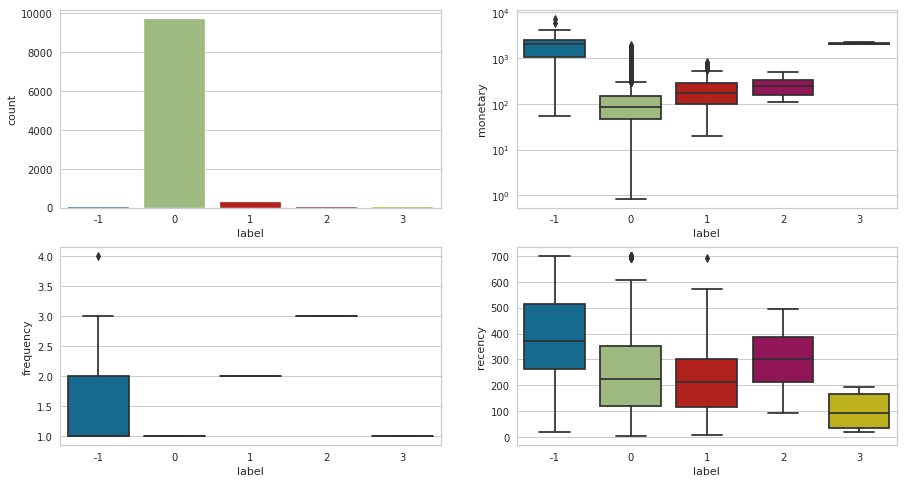

In [44]:
fig4, ax = plt.subplots(2, 2, figsize=(15, 8))
sns.countplot(ax=ax[0, 0], data=X_min, x='label')
sns.boxplot(ax=ax[0, 1], data=X_min, x='label', y='monetary')
ax[0, 1].set(yscale='log')
sns.boxplot(ax=ax[1, 0], data=X_min, x='label', y='frequency')
sns.boxplot(ax=ax[1, 1], data=X_min, x='label', y='recency')

# K-Mean modele with review scores
## Selecting data

In [45]:
mean_review = pd.DataFrame(data[['customer_unique_id',
                                 'review_score',
                                 'n_purchase']])
mean_review = mean_review.groupby('customer_unique_id').\
              agg({'review_score': 'mean',
                   'n_purchase': 'sum'
                   }).reset_index()
mean_review = mean_review.rename(columns={'review_score': 'mean_rs'})

mean_review['mean_rs'] = mean_review.groupby('n_purchase')['mean_rs'].\
                         apply(lambda x: x.fillna(x.mean()))

mean_review.mean_rs = mean_review.mean_rs.round(2)
mean_review

customer_unique_id  mean_rs  n_purchase
0      0000366f3b9a7992bf8c76cfdf3221e2      5.0           1
1      0000b849f77a49e4a4ce2b2a4ca5be3f      4.0           1
2      0000f46a3911fa3c0805444483337064      3.0           1
3      0000f6ccb0745a6a4b88665a16c9f078      4.0           1
4      0004aac84e0df4da2b147fca70cf8255      5.0           1
...                                 ...      ...         ...
95415  fffcf5a5ff07b0908bd4e2dbc735a684      5.0           1
95416  fffea47cd6d3cc0a88bd621562a9d061      4.0           1
95417  ffff371b4d645b6ecea244b27531430a      5.0           1
95418  ffff5962728ec6157033ef9805bacc48      5.0           1
95419  ffffd2657e2aad2907e67c3e9daecbeb      5.0           1

[95420 rows x 3 columns]

In [1]:
#px.histogram(mean_review, x='mean_rs')

In [47]:
#sns.boxplot(data=mean_review, x='mean_rs')

1:1: E265 block comment should start with '# '


In [77]:
rfm_rs = pd.DataFrame(rfm[['customer_unique_id',
                           'recency',
                           'frequency',
                           'monetary']])
rfm_rs = pd.merge(rfm_rs, mean_review[['customer_unique_id', 'mean_rs']],
                  on='customer_unique_id', how='left')
rfm_rs
rfm_rs.to_csv('final_data.csv')

In [49]:
#sns.heatmap(rfm_rs.corr(), cmap='YlGnBu', annot=True)

1:1: E265 block comment should start with '# '


## K-value: elbow and score method

In [78]:
# Data matrix
X = pd.DataFrame(rfm_rs[['recency', 'frequency', 'monetary', 'mean_rs']])
# scaler
scaler = StandardScaler()
# transform data
X_trans = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
# describe
# X_trans.describe()

### Elbow method

In [51]:
rfm_rs_elbow = elbow_method(2, 10, X_trans)
fig2 = px.line(rfm_rs_elbow, x='k', y='Inertia',
               title='Elbow Method showing the optimal number of clusters',
               labels={'x': 'Number of clusters', 'y': 'Inertie'},
               width=800, height=600)
fig2.update_traces(mode='markers+lines')

### Score method

rfm_rs_score = sil_score(2, 7, X_trans)

rfm_rs_score

px.line(rfm_rs_score, x='k', y='sil_scores')

## Implemeting K-mean
- k=5
- scaler = StandardScaler

silhouette_diagram(k, model)